In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.colors import ListedColormap
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from skorch import NeuralNetRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import joblib
from cmdstanpy import CmdStanModel


sns.set(style='whitegrid')

In [6]:
# Loading the datasets
df1 = pd.read_csv('Datasets/direct1.csv')
df2 = pd.read_csv('Datasets/direct2.csv')
df3 = pd.read_csv('Datasets/indirect1.csv')
df4 = pd.read_csv('Datasets/indirect2.csv')
df4 = df4.rename(columns={'Pore radius [nm]': 'Pore diameter [nm]'})


In [8]:
print(df1.shape, df2.shape, df3.shape, df4.shape)

(63, 6) (36, 9) (96, 8) (36, 11)


In [9]:
cols_2 = [ 'Permeability [nD]', 'Porosity [%]']
cols_5 = [ 'Permeability [nD]', 'Porosity [%]', 'SSA [m2g-1]', 'Pore diameter [nm]', 'Clay content [%]']
target = 'Breakthrough pressure [MPa]'

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import numpy as np

def preprocess_data(df, feature_cols, target_col, 
                    apply_log_transform=False, 
                    polynomial_degree=None, 
                    remove_outliers=True):
    # Drop rows with missing values
    df = df.dropna(subset=feature_cols + [target_col])
    
    # Optional: Remove outliers using Z-scores
    if remove_outliers:
        z_scores = np.abs((df[feature_cols] - df[feature_cols].mean()) / df[feature_cols].std())
        df = df[(z_scores < 3).all(axis=1)]  # Remove rows with Z-score > 3
    
    # Splitting data into features and target
    X = df[feature_cols]
    y = df[target_col]
    
    # Optional: Transform the target using a log transform if target is strictly positive
    if apply_log_transform and (y > 0).all():
        y = np.log(y)
    
    # Standardizing features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Optional: Polynomial features to capture non-linear relationships
    if polynomial_degree and polynomial_degree > 1:
        poly = PolynomialFeatures(degree=polynomial_degree, include_bias=False)
        X_scaled = poly.fit_transform(X_scaled)
    
    # Splitting into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, 
                                                        test_size=0.2, 
                                                        random_state=42)
    
    return X_train, X_test, y_train, y_test, scaler

# Example usage:
feature_cols_2 = ['Permeability [nD]', 'Porosity [%]']
feature_cols_5 = ['Permeability [nD]', 'Porosity [%]', 'SSA [m2g-1]', 'Pore diameter [nm]', 'Clay content [%]']
target_col = 'Breakthrough pressure [MPa]'

# For df1 with fewer features
X_train1, X_test1, y_train1, y_test1, scaler1 = preprocess_data(
    df1, 
    feature_cols_2, 
    target_col,
    apply_log_transform=False,           # Apply log transform to target if beneficial
    polynomial_degree=2,                 # Add polynomial features for non-linear relationships
    remove_outliers=True
)

# For df2 with more features
X_train2, X_test2, y_train2, y_test2, scaler2 = preprocess_data(
    df2, 
    feature_cols_5, 
    target_col,
    apply_log_transform=True,           # No log transform if not beneficial
    polynomial_degree=2,                # Experiment with polynomial features
    remove_outliers=True
)

X_train3, X_test3, y_train3, y_test3, scaler3 = preprocess_data(
    df3, 
    feature_cols_2, 
    target_col,
    apply_log_transform=True,           # No log transform if not beneficial
    polynomial_degree=2,                # Experiment with polynomial features
    remove_outliers=True
)

X_train4, X_test4, y_train4, y_test4, scaler4 = preprocess_data(
    df4, 
    feature_cols_5, 
    target_col,
    apply_log_transform=True,           # No log transform if not beneficial
    polynomial_degree=2,                # Experiment with polynomial features
    remove_outliers=True
)



# GPR

In [54]:
# Step 1: Import necessary libraries
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error, r2_score

X_train = X_train2
y_train = y_train2
X_test = X_test2
y_test = y_test2

kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.01, length_scale_bounds=(1e-3, 1e3))

gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0005, n_restarts_optimizer=5, normalize_y=True, random_state=42)

gpr.fit(X_train, y_train)

y_pred, y_std = gpr.predict(X_test, return_std=True)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R^2 Score:", r2)

# Step 7: (Optional) Check the learned kernel parameters
print("Optimized kernel:", gpr.kernel_)
print("Log-marginal-likelihood:", gpr.log_marginal_likelihood(gpr.kernel_.theta))

# Step 8: (Optional) Use the predictive standard deviation (y_std) 
# to understand the uncertainty of the predictions
# For example, you could print the first 5 predictions with uncertainty:
y_test = y_test.reset_index(drop=True)
for i in range(min(5, len(y_test))):
    print(f"Prediction: {y_pred[i]:.3f} ± {y_std[i]:.3f}, True Value: {y_test[i]}")


Mean Squared Error (MSE): 0.16704416978223394
R^2 Score: 0.8090515324371064
Optimized kernel: 0.947**2 * RBF(length_scale=0.0388)
Log-marginal-likelihood: -23.670699160963455
Prediction: 0.988 ± 0.991, True Value: 0.3852624007906449
Prediction: 2.143 ± 0.343, True Value: 2.186051276738094
Prediction: -0.769 ± 0.103, True Value: -0.843970070294529
Prediction: 1.159 ± 0.940, True Value: 1.0296194171811581
Prediction: 0.698 ± 0.182, True Value: 1.0986122886681098


In [51]:
def reverse_transform(y_pred_scaled, y_true_scaled):
    """
    Reverse the scaling and optional log transformation for predictions and true values.
    
    Parameters:
        y_pred_scaled (np.array): Scaled predictions.
        y_true_scaled (np.array): Scaled true values.
        scaler_y (StandardScaler): Scaler used for the target variable.
        log_transform_applied (bool): Whether log transformation was applied.
    
    Returns:
        y_pred_original (np.array): Predictions in the original scale.
        y_true_original (np.array): True values in the original scale.
    """
    # Ensure predictions and true values are reshaped to 2D arrays
    y_pred_scaled = np.array(y_pred_scaled).reshape(-1, 1)
    y_true_scaled = np.array(y_true_scaled).reshape(-1, 1)
    
    # Reverse log transformation if applied
    y_pred_original = np.exp(y_pred_scaled)
    y_true_original = np.exp(y_true_scaled)
    
    return y_pred_original.flatten(), y_true_original.flatten()

y_pred_original, y_test_original = reverse_transform(y_pred, y_test2)

In [52]:
y_pred_scaled = np.array(y_pred).reshape(-1, 1)

In [41]:
y_pred_scaled

array([[ 4.89208333],
       [10.73447581],
       [ 4.89208333],
       [ 9.85753525],
       [ 4.89208333],
       [ 4.89208333],
       [ 4.89208333],
       [ 4.89208333],
       [ 4.89208333],
       [ 4.89208333],
       [ 9.85751007],
       [ 4.89208333],
       [ 5.31783894]])

In [12]:
df1.columns

Index(['Reference', 'Rock', 'P’[MPa]', 'Permeability [nD]', 'Porosity [%]',
       'Breakthrough pressure [MPa]'],
      dtype='object')

Mean error: 0.281513145995
Standard deviation of errors: 1.0102234408153254


/var/folders/xp/jy5j7tmd2c7bsktzm4pdpxm40000gn/T/ipykernel_41211/1984631697.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test_array.min(), y_test_array.max()],


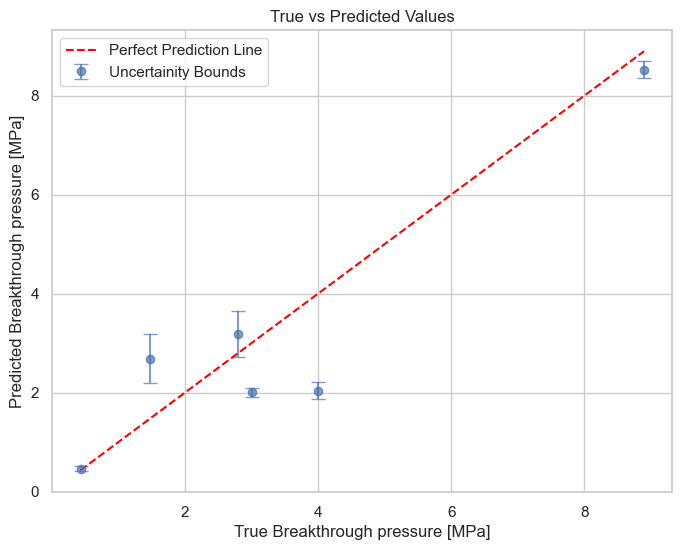

Sample 0: True = 1.47, Pred = 0.988 ± 0.991
Sample 1: True = 8.9, Pred = 2.143 ± 0.343
Sample 2: True = 0.43, Pred = -0.769 ± 0.103
Sample 3: True = 2.8, Pred = 1.159 ± 0.940
Sample 4: True = 3.0000000000000004, Pred = 0.698 ± 0.182


In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure y_test is a numpy array for consistent indexing
y_test_array = np.array(y_test_original)

# Calculate the residual errors
errors = y_test_array - y_pred_original

# Print the mean and standard deviation of the errors
print("Mean error:", np.mean(errors))
print("Standard deviation of errors:", np.std(errors))

# Plot the true vs. predicted values
plt.figure(figsize=(8, 6))
# Add capsize to draw horizontal lines at error bar ends
plt.errorbar(y_test_array, y_pred_original, yerr=(y_std/2), fmt='o', alpha=0.7, 
             label='Uncertainity Bounds', capsize=5)

plt.plot([y_test_array.min(), y_test_array.max()],
         [y_test_array.min(), y_test_array.max()],
         'k--', label='Perfect Prediction Line', color="red")

plt.xlabel('True Breakthrough pressure [MPa]')
plt.ylabel('Predicted Breakthrough pressure [MPa]')
plt.title('True vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


# If you'd like the standard deviation per predicted point, it's already in y_std.
# For example, you can print them:
for i in range(min(5, len(y_std))):
    print(f"Sample {i}: True = {y_test_array[i]}, Pred = {y_pred[i]:.3f} ± {y_std[i]:.3f}")


In [60]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Assuming y_test and y_pred are defined
r2 = r2_score(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)

print("R² Score:", r2)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

R² Score: 0.8488908341717061
Mean Squared Error (MSE): 1.0998010517407575
Mean Absolute Error (MAE): 0.8276525157027822


# Bayesian Ridge

/var/folders/xp/jy5j7tmd2c7bsktzm4pdpxm40000gn/T/ipykernel_41211/1128448001.py:51: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(d, d, 'k--', lw=2, color='red', label='$x = y$ (Ideal Fit)')


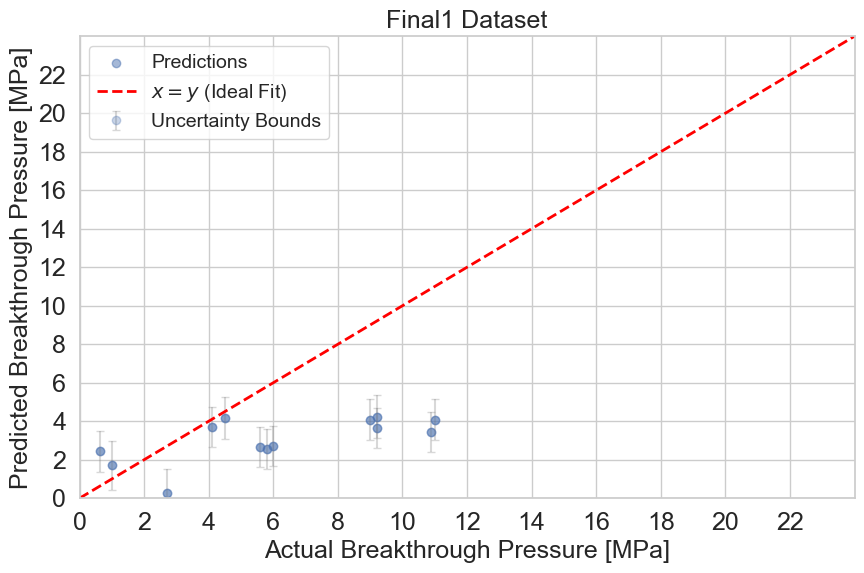

Evaluation Metrics for Final1 Dataset:
Mean Absolute Error (MAE): 0.8700
Mean Squared Error (MSE): 1.0310
R-squared (R2): -0.3888



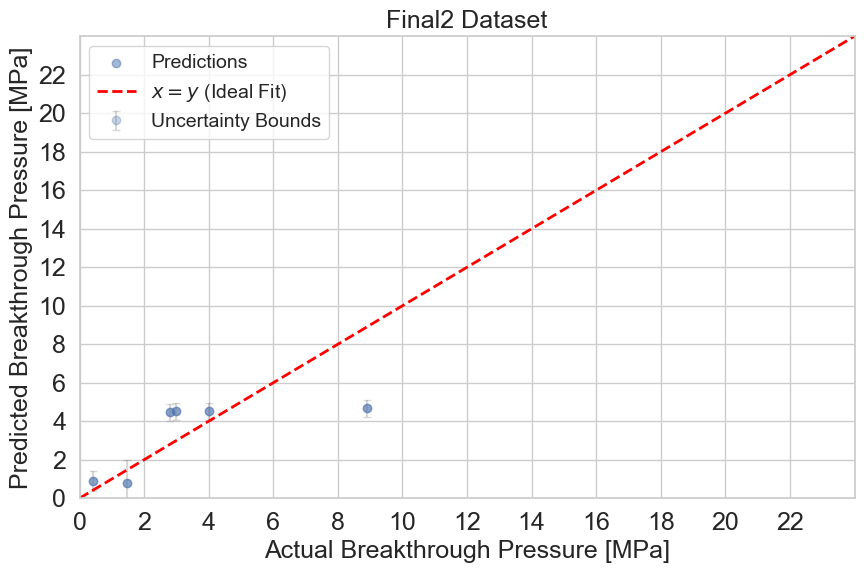

Evaluation Metrics for Final2 Dataset:
Mean Absolute Error (MAE): 0.4977
Mean Squared Error (MSE): 0.2875
R-squared (R2): 0.6714



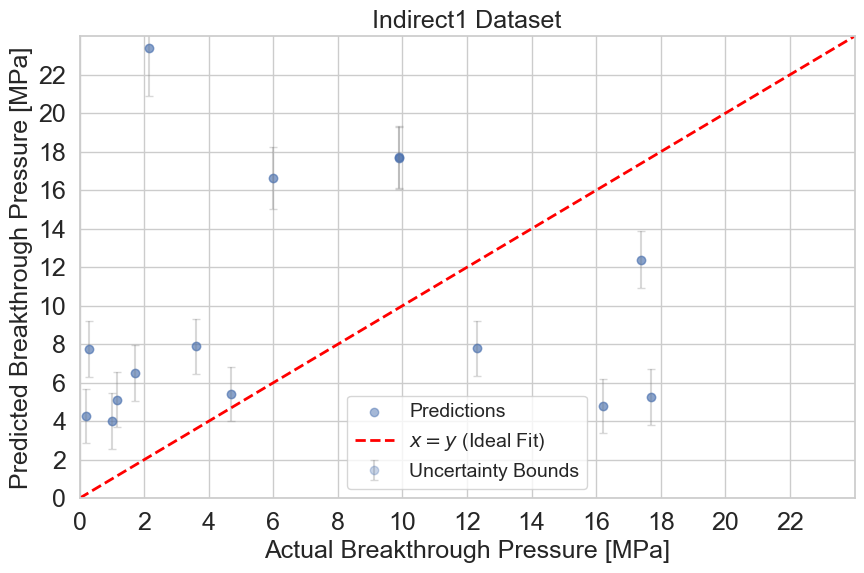

Evaluation Metrics for Indirect1 Dataset:
Mean Absolute Error (MAE): 1.3959
Mean Squared Error (MSE): 2.6795
R-squared (R2): 0.0851



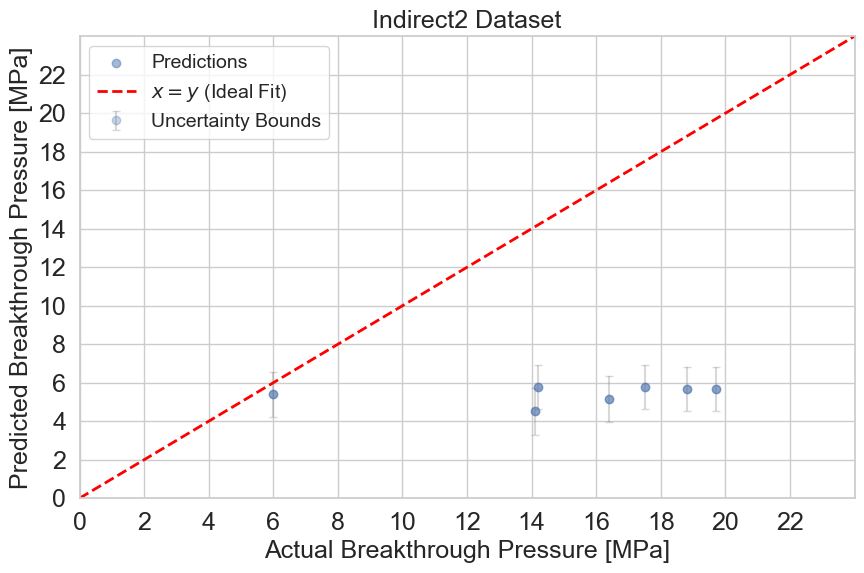

Evaluation Metrics for Indirect2 Dataset:
Mean Absolute Error (MAE): 0.9779
Mean Squared Error (MSE): 1.0932
R-squared (R2): -6.7192



In [66]:
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt


def bayesian_regression(df, features, target):
    X = df[features]
    y = df[target]
    
    X_train, X_test, y_train, y_test, scaler = preprocess_data(df, 
                                                            features, 
                                                                target,
                                                                apply_log_transform=True,           # No log transform if not beneficial
                                                                polynomial_degree=2,                # Experiment with polynomial features
                                                                remove_outliers=True)
    
    param_grid = {
        'alpha_1': [1e-6, 1e-5, 1e-4],
        'alpha_2': [1e-6, 1e-5, 1e-4],
        'lambda_1': [1e-6, 1e-5, 1e-4],
        'lambda_2': [1e-6, 1e-5, 1e-4]
    }
    grid_search = GridSearchCV(BayesianRidge(), param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    
    y_pred, y_std = best_model.predict(X_test, return_std=True)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return y_test, y_pred, y_std, mae, mse, r2


def plot_results(y_test, y_pred, y_std, mae, mse, r2, title='Bayesian Regression Results'):
    
    y_pred, y_test = reverse_transform(y_pred, y_test)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
    plt.errorbar(y_test, y_pred, yerr=y_std, fmt='o', alpha=0.3, 
                 ecolor='gray', capsize=3, label='Uncertainty Bounds')
    
    
    d = np.linspace(0,
                100, 100)
    plt.plot(d, d, 'k--', lw=2, color='red', label='$x = y$ (Ideal Fit)')
    
    
    plt.xlim([0, 24])
    plt.ylim([0, 24])
    plt.xlabel('Actual Breakthrough Pressure [MPa]', fontsize=18)
    plt.ylabel('Predicted Breakthrough Pressure [MPa]', fontsize=18)
    plt.title(title, fontsize=18)
    plt.xticks(np.arange(0, 24, 2), fontsize=18)
    plt.yticks(np.arange(0, 24, 2), fontsize=18)
    plt.legend(fontsize=14)
    plt.show()
    
    print(f"Evaluation Metrics for {title}:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R2): {r2:.4f}\n")


y_test_1, y_pred_1, y_std_1, mae_1, mse_1, r2_1 = bayesian_regression(df1, cols_2, target)
y_test_2, y_pred_2, y_std_2, mae_2, mse_2, r2_2 = bayesian_regression(df2, cols_5, target)
y_test_3, y_pred_3, y_std_3, mae_3, mse_3, r2_3 = bayesian_regression(df3, cols_2, target)
y_test_4, y_pred_4, y_std_4, mae_4, mse_4, r2_4 = bayesian_regression(df4, cols_5, target)

plot_results(y_test_1, y_pred_1, y_std_1, mae_1, mse_1, r2_1, title='Final1 Dataset')
plot_results(y_test_2, y_pred_2, y_std_2, mae_2, mse_2, r2_2, title='Final2 Dataset')
plot_results(y_test_3, y_pred_3, y_std_3, mae_3, mse_3, r2_3, title='Indirect1 Dataset')
plot_results(y_test_4, y_pred_4, y_std_4, mae_4, mse_4, r2_4, title='Indirect2 Dataset')